# Advanced ML: Домашнее задание 1
Это задание связано с анализом конкретного датасета, в котором, надеюсь, понадобится то, чему мы с вами до сих пор научились. В качестве решения ожидается ссылка на jupyter-ноутбук на вашем github (или публичный, или с доступом для snikolenko); ссылку обязательно нужно прислать в виде сданного домашнего задания на портале Академии. Любые комментарии, новые идеи и рассуждения на тему в этом ноутбуке категорически приветствуются. Датасет давайте возьмём довольно релевантный реальной жизни; он доступен по следующей ссылке:
https://ourworldindata.org/coronavirus-source-data


1) Скачайте данные в формате csv, выберите из таблицы данные по России, начиная с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших). В качестве целевой переменной возьмём число случаев заболевания (столбцы total_cases и new_cases); для упрощения обработки можно заменить в столбце new_cases все нули на единицы. Для единообразия давайте зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта; остальные данные можно использовать в качестве тестового набора (и он даже будет увеличиваться по мере выполнения задания).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

from scipy.stats import multivariate_normal

In [2]:
df = pd.read_csv("https://covid.ourworldindata.org/data/owid-covid-data.csv")
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [3]:
df_ru = df \
.loc[(df["location"] == "Russia") & (df["date"] >= "2020-03-03")] \
.replace({"new_cases": 0}, 1) \
.filter(items=["date", "new_cases"]) \
.reset_index(drop=True)

df_ru["total_cases"] = df_ru["new_cases"].cumsum()
df_ru["day"] = df_ru.index + 1
df_ru["day_2"] = (df_ru["day"]) ** 2
df_ru.set_index("date", inplace=True)
df_ru.index = pd.DatetimeIndex(df_ru.index, freq="d")

In [54]:
df_ru.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 748 entries, 2020-03-03 to 2022-03-20
Freq: D
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   new_cases    748 non-null    float64
 1   total_cases  748 non-null    float64
 2   day          748 non-null    int64  
 3   day_2        748 non-null    int64  
dtypes: float64(2), int64(2)
memory usage: 29.2 KB


In [5]:
train_size = 50

Xy_train = df_ru[:train_size]
Xy_test = df_ru[train_size:]

In [6]:
Xy_test.shape

(698, 4)

2) Постройте графики целевых переменных. Вы увидите, что число заболевших растёт очень быстро, на первый взгляд экспоненциально. Для первого подхода к снаряду давайте это и используем.

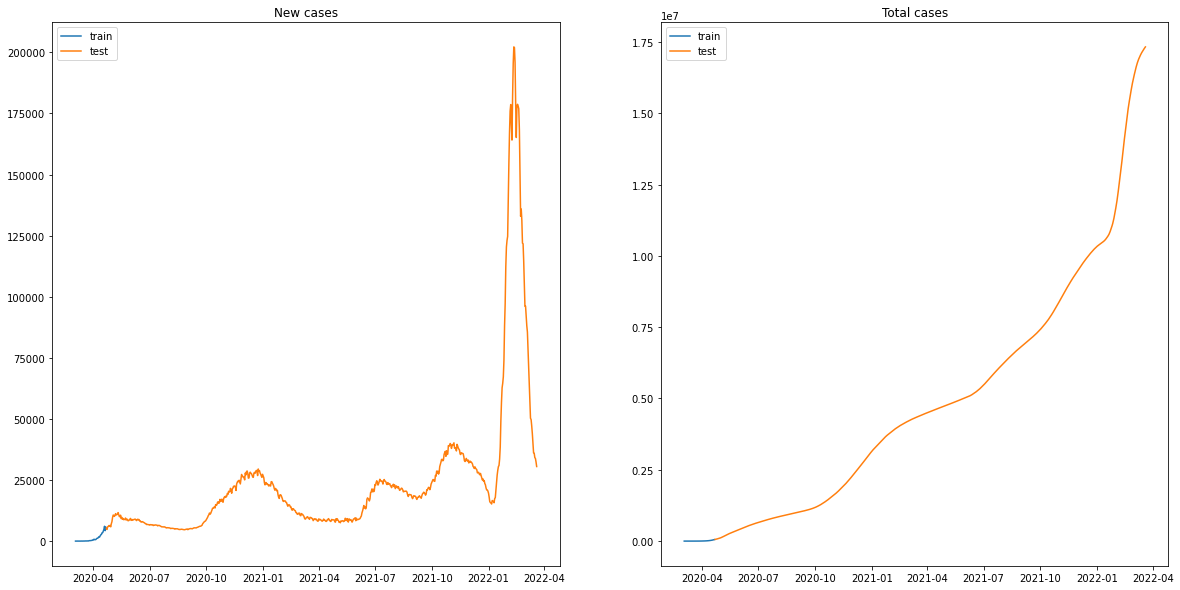

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].plot(Xy_train["new_cases"], label="train")
axes[0].plot(Xy_test["new_cases"], label="test")
axes[0].legend(loc="upper left")
axes[0].set_title("New cases")

axes[1].plot(Xy_train["total_cases"], label="train")
axes[1].plot(Xy_test["total_cases"], label="test")
axes[1].legend(loc="upper left")
axes[1].set_title("Total cases")

plt.show()

    a) Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер текущего дня.

In [8]:
lr = LinearRegression()

lr.fit(Xy_train[["day"]], np.log(Xy_train["new_cases"]))

print("ln y ~ ax + b")
print("a:", lr.coef_[0])
print("b:", lr.intercept_)

ln y ~ ax + b
a: 0.18596309168510516
b: 0.13472442721454314


In [55]:
class BayesianLinearRegression:
    def __init__(self, mu0, sigma0):
        self.mu0 = mu0
        self.sigma0 = sigma0
        self.mu = mu0
        self.sigma = sigma0
        self.is_fitted = False
    
    def __repr__(self):
        return f"{self.__class__.__name__}(mu0 = {self.mu0}, sigma0 = {self.sigma0})"
    
    @staticmethod
    def add_ones(X):
        return np.hstack((X, np.ones((len(X), 1))))
    
    @staticmethod
    def estimate_noise(X, y):
        w = np.linalg.inv(X.T @ X) @ X.T @ y
        noise = np.var(y - X @ w)
        return noise
    
    def bayesian_update(self, X, y, noise):
        sigma = np.linalg.inv(self.sigma0) + X.T @ X / noise
        self.sigma = np.linalg.inv(sigma)
        
        mu = np.linalg.inv(self.sigma0) @ self.mu0 + X.T @ y / noise
        self.mu = self.sigma @ mu
    
    def fit(self, X, y):
        X = self.add_ones(X)
        noise = self.estimate_noise(X, y)
        self.bayesian_update(X, y, noise)
        self.is_fitted = True
        return self
    
    def predict(self, X):
        X = self.add_ones(X)
        return X @ self.mu
    
    def sample_predict(self, X, n):
        X = self.add_ones(X)
        w_sample = np.random.multivariate_normal(self.mu, self.sigma, n)
        res = []
        for w in w_sample:
            res.append(X @ w)
        return np.array(res)

In [56]:
blr = BayesianLinearRegression(
    mu0 = np.zeros((2,)),
    sigma0 = 100 * np.eye(2)
)
blr.fit(Xy_train[["day"]], np.log(Xy_train["new_cases"]))

BayesianLinearRegression(mu0 = [0. 0.], sigma0 = [[100.   0.]
 [  0. 100.]])

In [57]:
print("ln y ~ ax + b")
print("a:", blr.mu[0])
print("b:", blr.mu[1])

ln y ~ ax + b
a: 0.18596420019604432
b: 0.13468658911282105


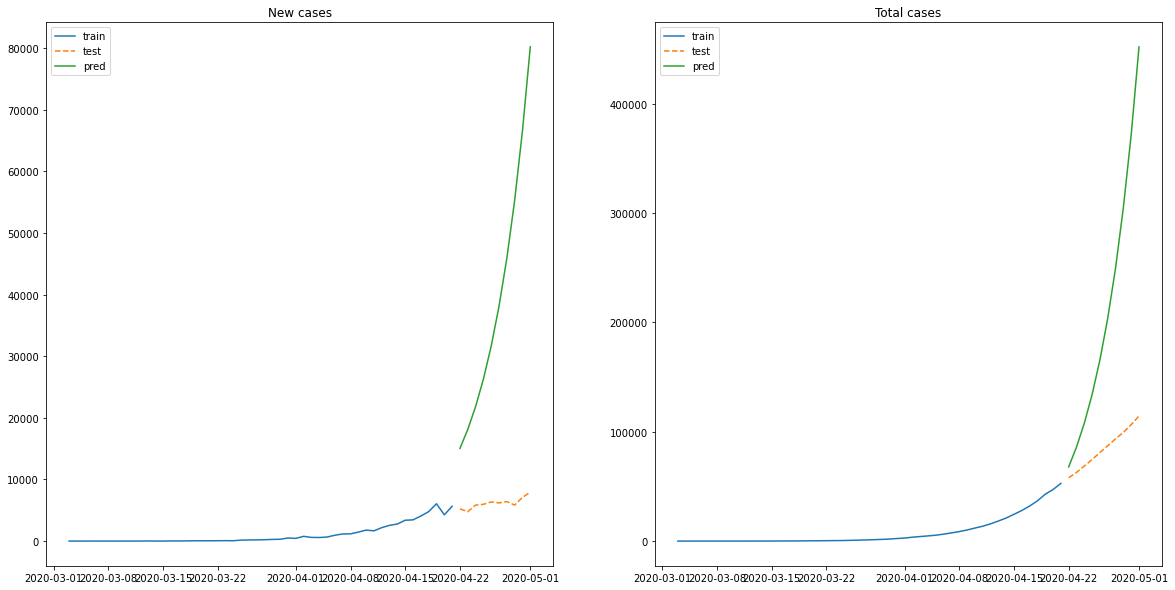

In [76]:
forecast_period = 10

blr_pred = Xy_test[["day"]].copy()
blr_pred["new_cases"] = np.exp(blr.predict(Xy_test[["day"]]))
blr_pred["total_cases"] = np.cumsum(blr_pred["new_cases"]) + Xy_train["total_cases"][-1]

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].plot(Xy_train["new_cases"], label="train")
axes[0].plot(Xy_test.iloc[:forecast_period].loc[:, "new_cases"], linestyle = '--', label="test")
axes[0].plot(blr_pred.iloc[:forecast_period].loc[:, "new_cases"], label="pred")
axes[0].legend(loc="upper left")
axes[0].set_title("New cases")

axes[1].plot(Xy_train["total_cases"], label="train")
axes[1].plot(Xy_test.iloc[:forecast_period].loc[:, "total_cases"], linestyle = '--', label="test")
axes[1].plot(blr_pred.iloc[:forecast_period].loc[:, "total_cases"], label="pred")
axes[1].legend(loc="upper left")
axes[1].set_title("Total cases")

plt.show()

<ipython-input-71-d37312154cb4>:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)


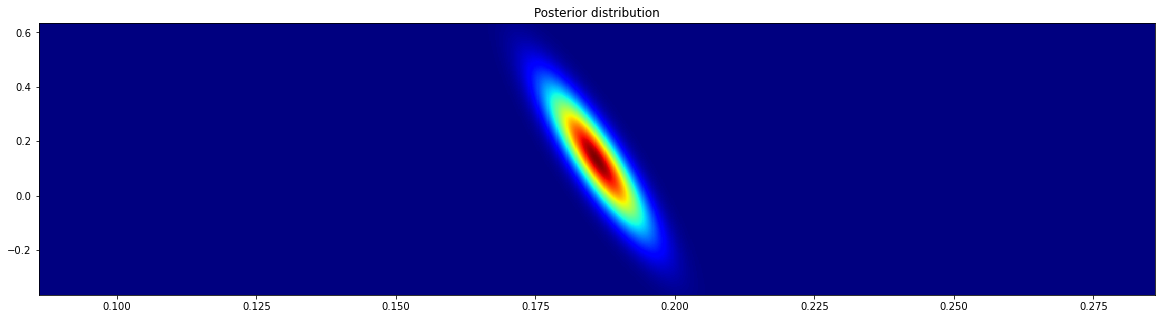

In [71]:
space_size = 1000

x_lim = (blr.mu[0] - .1, blr.mu[0] + .1)
y_lim = (blr.mu[1] - .5, blr.mu[1] + .5)

X = np.linspace(*x_lim, space_size)
Y = np.linspace(*y_lim, space_size)
X, Y = np.meshgrid(X, Y)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y


Z = multivariate_normal.pdf(pos, mean=blr.mu, cov=blr.sigma)

plt.figure(figsize=(20, 5))
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)
plt.title("Posterior distribution")
plt.show()

    c) Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).

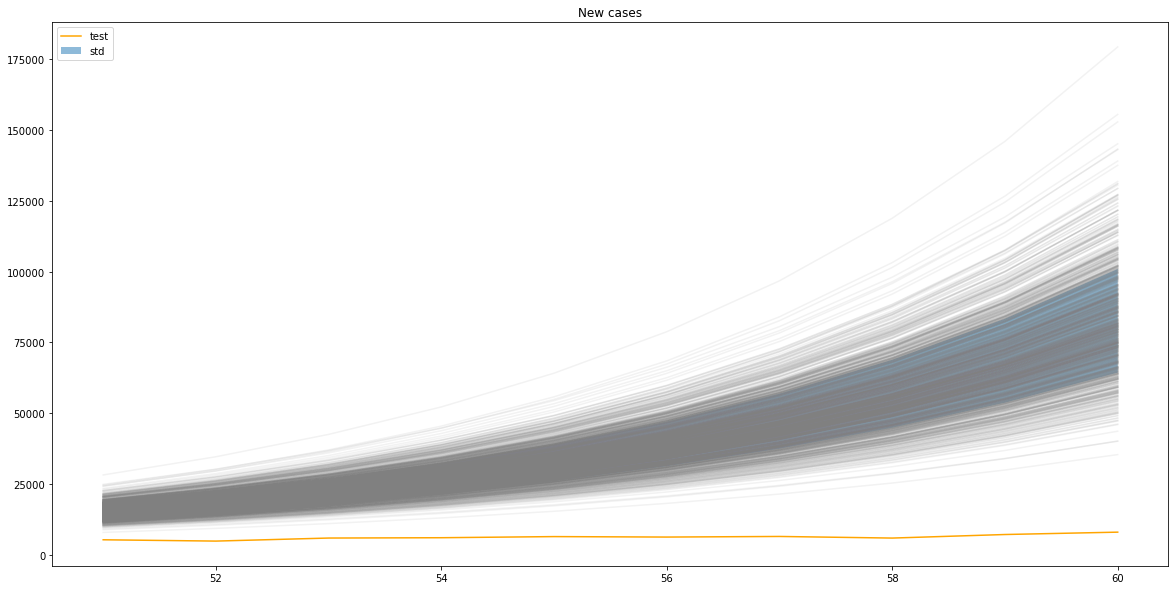

In [73]:
forecast_data = Xy_test.iloc[:forecast_period][["day"]]
sample_pred = np.exp(blr.sample_predict(forecast_data, 1000))


plt.figure(figsize=(20, 10))
for pred in sample_pred:
    plt.plot(forecast_data, pred, alpha=.1, color="grey")
plt.plot(
    forecast_data, Xy_test.iloc[:forecast_period]["new_cases"].values, 
    label="test", color="orange"
)

lb = np.mean(sample_pred, axis=0) - np.std(sample_pred, axis=0) 
ub = np.mean(sample_pred, axis=0) + np.std(sample_pred, axis=0)
plt.fill_between(forecast_data.squeeze(), lb, ub, alpha=.5, label="std")

plt.title("New cases")
plt.legend()
plt.show()

In [62]:
print("1 may: ", int(blr_pred.loc["2020-05-01"]["total_cases"]))
print("1 june: ", int(blr_pred.loc["2020-06-01"]["total_cases"]))
print("1 september: ", int(blr_pred.loc["2020-09-01"]["total_cases"]))

1 may:  451878
1 june:  150734887
1 september:  4059669213998487


3) Предсказания экспоненциальной модели наверняка получились грустными. Но это, конечно, чересчур пессимистично — экспоненциальный рост в природе никак не может продолжаться вечно. Кривая общего числа заболевших во время эпидемии в реальности имеет сигмоидальный вид: после начальной фазы экспоненциального роста неизбежно происходит насыщение. В качестве конкретной формы такой сигмоиды давайте возьмём форму функции распределения для гауссиана 

Естественно, в нашем случае сигмоида стремится не к единице, т.е. константа перед интегралом может быть произвольной (и её можно внести в экспоненту), а в экспоненте под интегралом может быть произвольная квадратичная функция от t.

    a) Предложите способ обучать параметры такой сигмоидальной функции при помощи линейной регрессии.

Продифференцируем total_cases слева и сигмоиду справа:

$y' = e^{ax^{2} + bx + c}$ \
$ln y' =  ax^{2} + bx + c$

В качестве y' можно взять new_cases

    b) Обучите эти параметры на датасете случаев коронавируса в России. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели.

In [63]:
blr_s = BayesianLinearRegression(
    mu0=np.zeros(3,),
    sigma0=100 * np.eye(3)
)

blr_s.fit(Xy_train[["day", "day_2"]], np.log(Xy_train["new_cases"]))

print("a:", blr_s.mu[0])
print("b:", blr_s.mu[1])
print("c:", blr_s.mu[2])

a: 0.27925642367315673
b: -0.0018293596903643725
c: -0.6737180019324143


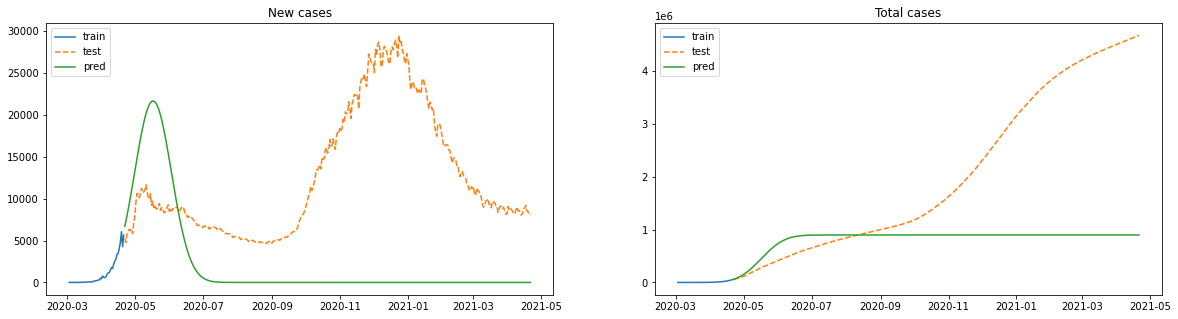

In [68]:
blr_s_pred = Xy_test[["day", "day_2"]].copy()
blr_s_pred["new_cases"] = np.exp(blr_s.predict(Xy_test[["day", "day_2"]]))
blr_s_pred["total_cases"] = np.cumsum(blr_s_pred["new_cases"]) + Xy_train["total_cases"][-1]

fig, axes = plt.subplots(1, 2, figsize=(20, 5))

axes[0].plot(Xy_train["new_cases"], label="train")
axes[0].plot(Xy_test.iloc[:forecast_period].loc[:, "new_cases"], linestyle = '--', label="test")
axes[0].plot(blr_s_pred.iloc[:forecast_period].loc[:, "new_cases"], label="pred")
axes[0].legend(loc="upper left")
axes[0].set_title("New cases")

axes[1].plot(Xy_train["total_cases"], label="train")
axes[1].plot(Xy_test.iloc[:forecast_period].loc[:, "total_cases"], linestyle = '--', label="test")
axes[1].plot(blr_s_pred.iloc[:forecast_period].loc[:, "total_cases"], label="pred")
axes[1].legend(loc="upper left")
axes[1].set_title("Total cases")

plt.show()

    c) Посэмплируйте много разных сигмоид из апостериорного распределения, постройте графики. Сколько, исходя из этих сэмплов, будет всего случаев коронавируса в России? Постройте эмпирическое предсказательное распределение, нарисуйте графики. Каков ваш прогноз числа случаев коронавируса в пессимистичном сценарии (90-й процентиль в выборке числа случаев)? В оптимистичном сценарии (10-й процентиль)?

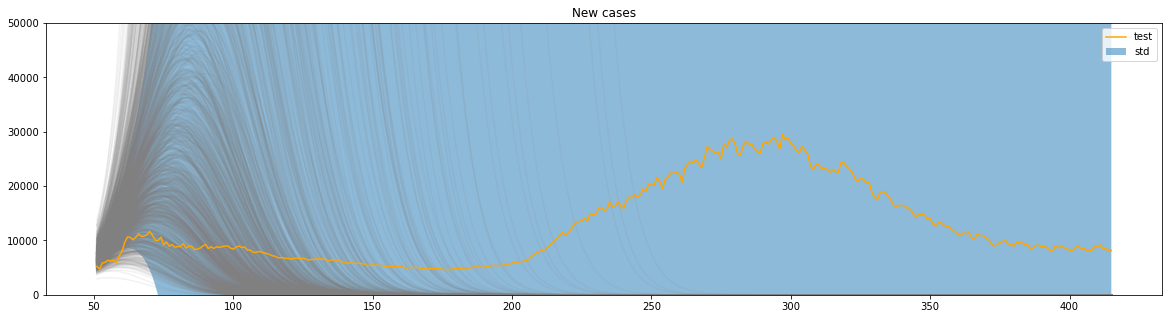

In [67]:
forecast_period = 365
forecast_data = Xy_test.iloc[:forecast_period][["day", "day_2"]]
sample_pred = np.exp(blr_s.sample_predict(forecast_data, 1000))


plt.figure(figsize=(20, 5))
for pred in sample_pred:
    plt.plot(forecast_data["day"], pred, alpha=.1, color="grey")
plt.plot(
    forecast_data["day"], Xy_test.iloc[:forecast_period]["new_cases"].values, 
    label="test", color="orange"
)

lb = np.mean(sample_pred, axis=0) - np.std(sample_pred, axis=0) 
ub = np.mean(sample_pred, axis=0) + np.std(sample_pred, axis=0)
plt.fill_between(forecast_data["day"], lb, ub, alpha=.5, label="std")

plt.ylim((0, 5e4))
plt.title("New cases")
plt.legend()
plt.show()

In [66]:
sample_pred_total = sample_pred.sum(axis=1)
sample_pred_total += Xy_train["total_cases"][-1]

print("Pessimistic scenario:", int(np.quantile(sample_pred_total, 0.9)))
print("Optimistic scenario:", int(np.quantile(sample_pred_total, 0.1)))

Pessimistic scenario: 5685872
Optimistic scenario: 330916
